# Heralded Erasure Decoder

This is short demo of how one might use the heralded erasure decoder. As I am still in the process of developing the decoder, its modularity is currently rather limited. In this notebook, I will demonstrate how to create, sample, and decode a rotated surface code circuit in which qubits are exposed to the pure erasure channel with perfect measurements. I hope that in the following months, I will be able to build and demonstrate a more customizable and versatile decoder.

## Building Erasure Circuits

An erasure circuit is one in which some subset of the qubits experience biased (perfectly biased) noise such that the overwhelmingly most likely (certain) error mechanism is a leakage. We assume this leakage is perfectly detectable, informing us of the location of the error (hence, heralded). A leaked qubit state is mathematically equivalent to the initial state having undergone perfectly symmetric $I$, $X$, $Y$, or $Z$, noise (i.e. the perfectly depolarizing channel).

First, we build our rotated surface code. This is done using the codes module.

In [1]:
# run the code below to use the right path
import sys
sys.path.append('../..')

In [2]:
from stimdecoders.utils import codes

In [5]:
# Build a rotated surface code of distance 3
rsc = codes.RSC(distance=3)

You can draw the lattice of the surface code, and the CNOT gates for the stabilizer check using the following two functions:

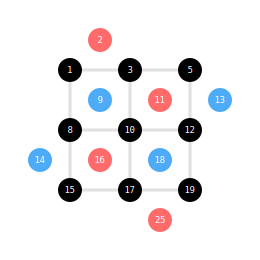

In [6]:
# draw the surface code lattice
rsc.draw_lattice()

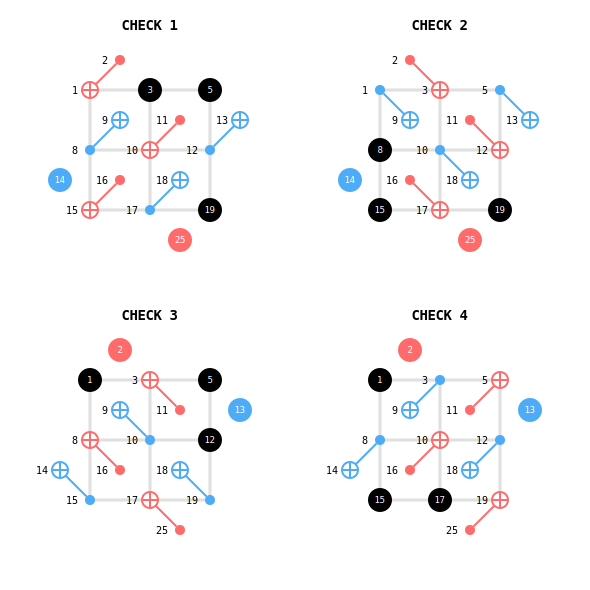

In [7]:
# draw the surface code checks
rsc.draw_checks()

To build an erasure circuit, we first need to provide the probabilities of noise in the system. For now, we assume that all qubits can either undergo symmetric Pauli noise, or perfectly biased erasure noise. We will store our noise model in a dictionary (I am still considering the best way to create an object for the noise model).

In [8]:
noise_dict = {
    'sp': 0.001,
    'sp-e': 0.01,
    'sqg': 0.001,
    'sqg-e': 0.01,
    'tqg': 0.001,
    'tqg-e': 0.01,
}

Currently, these are the only 6 types of supported noise. They correspond to the following:
- ```sp```: state preparation
- ```sqg```: single-qubit gates
- ```tqg```: two-qubit gates

The ```-e``` flag is the corresponding error probability for erasure qubits. In this example, the state preparation depolarization probability will be $0.001$ for a Pauli qubit (a qubit which experiences Pauli noise) and the state preparation erasure probability will be $0.01$ for an erasure qubit (a qubit which experiences erasure noise).

Before we build our heralded erasure code, we must define which qubits are Pauli qubits and which qubits are erasure qubits (for now, the two are not independent: all non-Pauli qubits are erasure qubits as these are the only two noise types supported).

In [9]:
# all qubits are erasure qubits in this example
erasure_qubits = rsc.all_qubit_ids
pauli_qubits = []

Each qubit in the circuit has a unique 'id.' This is the identifier used in stim when performing gates on the qubit. The id's are displayed in the drawing of the code lattice and the checks. In the above, I have set all qubits to be erasure qubits. In time, I plan to include a more customizable approach to noise allocation. If you want to allocate differently, unfortunately the only way to achieve that currently is to directly append the relevant qubit ids.

In [ ]:
# qubits must be turned to bitmasks
from stimdecoders.utils import bitops
erasure_qubit_mask = bitops.indices_to_mask(erasure_qubits)
pauli_qubit_mask = bitops.indices_to_mask(pauli_qubits) # we could equivalently initialize this as 0b0

For efficiency, operations are performed using bitmasks. The erasure and Pauli bitmasks are integer bitstrings which contain '1's at the indices corresponding to erasure and Pauli qubits, respectively, and '0's everywhere else. We store these bitmasks in the noise_dict dictionary.

In [11]:
noise_dict['erasure-qubits'] = erasure_qubit_mask
noise_dict['pauli-qubits'] = pauli_qubit_mask

Now the initialization process is complete, we can actually build the erasure circuit.

In [12]:
from stimdecoders.hed import hed
# build the heralded erasure code
erasure_circuit = hed.build_heralded_erasure_circuit(code=rsc, noise_dict=noise_dict)

This circuit is an instance of ```stimdecoders.circuits.Circuit```. This is useful for a number of reasons, but if you simply want the stim circuit to see what's going on underneath the hood, there are two ways to achieve that:
- you can convert the ```stimdecoders.circuits.Circuit``` to a ```stim.Circuit``` object using the function ```to_stim_circuit()```
- you can initialize erasure_circuit as a stim circuit from the get-go (use ```build_heralded_erasure_stim_circuit``` instead of ```build_heralded_erasure_circuit```)

In [13]:
erasure_stim_circuit = erasure_circuit.to_stim_circuit()

You can probe this stim circuit as you would any other stim circuit. A word of warning: I have yet to introduce annotations into the stim circuits, so any diagrams outside of ```timeline-svg``` will not make much sense.

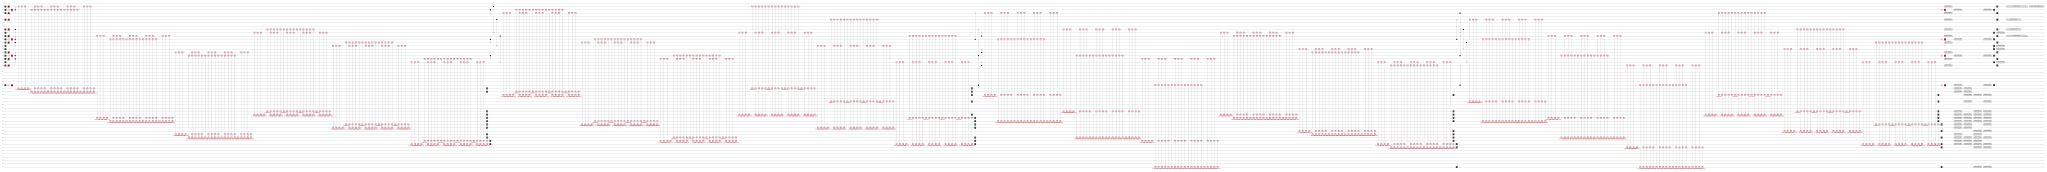

In [14]:
erasure_stim_circuit.diagram('timeline-svg')

This circuit looks quite complex for a simple distance 3 rotated surface code with a single round of syndrome extraction. The reason for this is that stim does not have any in-built features allowing for 2-qubit non-Pauli noise (e.g. erasure-erasure or Pauli-Pauli). Therefore, our solution is to create a number of fictitious qubits (```q26``` to ```q50```, in this case), the Z-basis state of which is directly correlated to the state of a real qubit (under noiseless conditions). We use measurements of these ancilla in the Z-basis to act as our heralds.

## Sampling Erasure Circuits

We can sample an erasure circuit just as we do any stim circuit. The method ```stimdetectors.hed.sample_erasure_circuit``` is built for just this purpose.

In [ ]:
syndromes, observable_flips = hed.sample_erasure_circuit(erasure_stim_circuit, num_shots=10) # you can also pass in a stimdetectors.circuits.Circuit object

## Decoding Erasure Circuits

The tough part is decoding. A traditional minimum-weight perfect matching (MWPM) will not do particularly well on this circuit directly, because of the existence of fictitious ancillas (among other things). Hence, we must manually extract the syndromes and build traditional Clifford circuits (circuits with no erasures). At any time along the circuit, if a qubit has undergone an erasure, it may be modelled having been passed through a perfectly depolarizing error channel (one-quarter probability of each possible Pauli error). Any qubit which does not undergo an erasure can be treated as noiseless.

In [18]:
clifford_circuit = hed.build_clifford_circuit(rsc, erasure_circuit, syndromes[0], noise_dict=noise_dict)

The above code builds the Clifford circuit corresponding to the first erasure syndrome we sampled. If you are unclear on what is going on, I highly recommend going through the various lines of each circuit, and seeing how they match up. You will find that the qubits which undergo depolarizing errors in the Clifford circuit are exactly those which are measured as having been erased (you can see this via the syndrome).

We can now use PyMatching to decode our Clifford circuit, but with the syndrome from our erasure circuit (the two circuits are equivalent, _a posteriori_). We will only consider the last 8 detector measurements from the syndrome, as these correspond to the detectors in the Clifford circuit (in this case, it is 8. More generally, the number of detectors is equal to the number of ancillas in the rotated surface code).

In [21]:
import pymatching
matching = pymatching.Matching.from_stim_circuit(clifford_circuit.to_stim_circuit())
decoded_flip = matching.decode(z=syndromes[0][-8:]) # only pass in the last 8 detectors

Stim stores the state of the observable (Flipped: ```True```, Unflipped: ```False```), and ```PyMatching.decode``` does the same, but as 0s and 1s. You will almost certainly find (unless you are very unlucky) that the ```observable_flips[0]``` and ```decoded_flips``` objects match.

In [22]:
observable_flips[0]

array([False])

In [23]:
decoded_flip

array([0], dtype=uint8)

This method of decoding can be rather slow, unfortunately. For this reason, I've built a (somewhat) time-efficient batch circuit-builder. You simply batch-sample a very large number of shots of the stim erasure circuit, and feed into the ```stimdecoders.hed.batch.BatchCircuitBuilder.build_batch()``` method, which will build a batch of Clifford circuits corresponding to syndromes.

In [26]:
from stimdecoders.hed import batch
batch_builder = batch.BatchCircuitBuilder(rsc=rsc, erasure_circuit=erasure_circuit, noise_dict=noise_dict) # only supports rotated surface codes
clifford_batch = batch_builder.build_batch(syndromes)
# an even faster method would be to use the build_batch_with_cache method (but this is more memory intensive)

You can then perform the decoding step on each of these Clifford circuits. If you'd rather skip ahead, you may choose to use the ```stimdecoders.hed.hed.batch_decode_pure_erasure_circuit()``` method. Pass in your erasure circuit, and the number of shots you'd like to run, and this function will automatically build your Clifford circuits _and_ decode them for you.

In [27]:
hed.batch_decode_pure_erasure_circuit(rsc=rsc, erasure_circuit=erasure_circuit, num_trials=10000, noise_dict=noise_dict)

2

The output of the above cell is the number of errors which occurred in ```num_trials``` trials. If you prefer the batch decoder to return the actual observable flip predictions for each, simply set the ```return_data``` argument (default: ```False```) to ```True```.